## Day 5 - Dollar Bars and Bollinger Bands

In [148]:
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objects as go

### Get the data

In [140]:
df = pd.read_csv('../dataset/BTC_1m_2021.csv')
df = df[["time","open","high","low","close","vol"]]

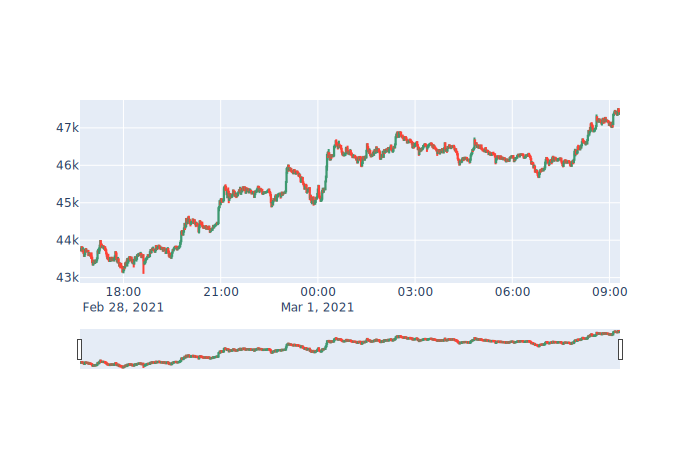

In [147]:
fig = go.Figure(data=[go.Candlestick(x=df.time,
                       open=df.open, high=df.high,
                       low=df.low, close=df.close)])
#fig.show()

#static rendering for git
fig.show("svg")

In [63]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S')

In [64]:
df_dict = df.to_dict('records') 
df_dict[0]

{'time': Timestamp('2021-02-28 16:40:00'),
 'open': 43743.88,
 'high': 43766.58,
 'low': 43720.54,
 'close': 43725.84,
 'vol': 36.32829413}

### Dollar bars

In [139]:
# source : https://davidzhao12.medium.com/advances-in-financial-machine-learning-for-dummies-part-1-7913aa7226f5

def get_dollar_bars(time_bars, dollar_threshold): #function credit to Max Bodoia

    # initialize an empty list of dollar bars
    dollar_bars = []

    # initialize the running dollar volume at zero
    running_volume = 0

    # initialize the running high and low with placeholder values
    running_high, running_low = 0, math.inf

    # for each time bar...
    for i in range(len(time_bars)):

        # get the timestamp, open, high, low, close, and volume of the next bar
        next_timestamp, next_open, next_high, next_low, next_close, next_volume = [time_bars[i][k] for k in ['time', 'open', 'high', 'low', 'close', 'vol']]

        # get the midpoint price of the next bar (the average of the open and the close)
        midpoint_price = ((next_open) + (next_close))/2

        # get the approximate dollar volume of the bar using the volume and the midpoint price
        dollar_volume = next_volume * midpoint_price

        # update the running high and low
        running_high, running_low = max(running_high, next_high), min(running_low, next_low)

        # if the next bar's dollar volume would take us over the threshold...
        if dollar_volume + running_volume >= dollar_threshold:

            # set the timestamp for the dollar bar as the timestamp at which the bar closed (i.e. one minute after the timestamp of the last minutely bar included in the dollar bar)
            bar_timestamp = next_timestamp + timedelta(minutes=1)
            
            # add a new dollar bar to the list of dollar bars with the timestamp, running high/low, and next close
            dollar_bars += [{'timestamp': bar_timestamp, 'open': next_open, 'high': running_high, 'low': running_low, 'close': next_close}]

            # reset the running volume to zero
            running_volume = 0

            # reset the running high and low to placeholder values
            running_high, running_low = 0, math.inf

        # otherwise, increment the running volume
        else:
            running_volume += dollar_volume

    # return the list of dollar bars
    return dollar_bars
    

#create bars 
dollar_bars = get_dollar_bars(df_dict, 100000) #100,000 is an arbitrarily selected threshold

#create dataframe
df = pd.DataFrame(dollar_bars)

## Bollinger Bands
The Bollinger Bands are developed by John Bollinger and they are a technical analysis tool for generating oversold and overbought signals. There are three lines: **(1)** a moving average (middle band), **(2)** upper bound, **(3)** lower bound. 

$$BOLU = MA(TP,n) + m \sigma[TP,n]$$
$$BOLD = MA(TP,n) - m \sigma[TP,n]$$

$BOLU$ : Upper band, $BOLD$ : Lower band, $MA$ : Moving average, $TP$ : Typical price ($(High + Low + Close)/3$), $n$ : Number of days, $m$ : Number of standard deviations, $\sigma[TP,n]$: Standard deviation over last $n$ periods of $TP$

Sources: <br />
**(a)** https://www.investopedia.com/terms/b/bollingerbands.asp <br />
**(b)** https://ai.plainenglish.io/start-using-better-labels-for-financial-machine-learning-6eeac691e660 <br />
**(c)** https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html <br />

In [75]:
"""
    :param close: DataFrame containing the closing prices
    :param window: window used for the moving average
    :param n_stdev: distance between the external bounds with the middle bar
    :return r_mean, upper_band, lower_band: Bollinger bands
"""
def getBbands(close, window, n_stdev):
    
    r_mean = close.rolling(window = window).mean()
    r_std = close.rolling(window = window).std()
    
    upper_band = r_mean + (r_std * n_stdev)
    lower_band = r_mean - (r_std * n_stdev)

    return r_mean, upper_band, lower_band

In [76]:
df_bands = df.copy()

In [96]:
window = 30
n_stdev = 1.5 # it is typically 2, but in this case there would be a few number of positions
df_bands['mean'], df_bands['upper'], df_bands['lower'] = getBbands(df_bands['close'],window, n_stdev=n_stdev)

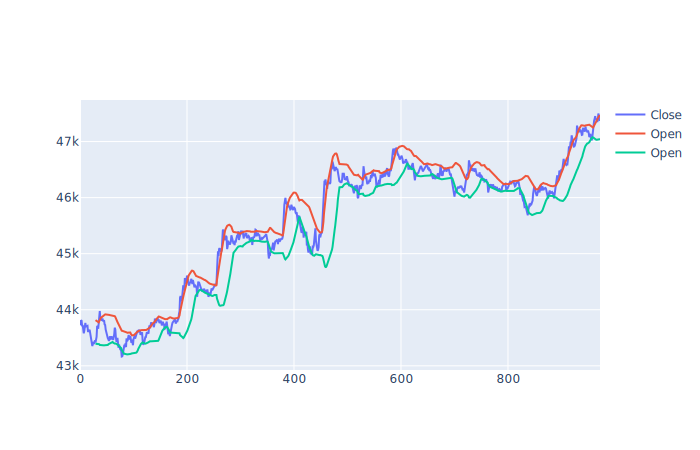

In [149]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=df_bands.index, y=df_bands['close'], name='Close'))
fig.add_trace(go.Scatter(x=df_bands.index, y=df_bands['upper'], name='Open'))
fig.add_trace(go.Scatter(x=df_bands.index, y=df_bands['lower'], name='Open'))

#fig.show()

#static rendering for git
fig.show("svg")

Given the upper and lower band, we have to define our triggers. Ideally, we should go **long** if the close price is lower than the lower band or **long** if the close price is greater than the upper band. 

Having a "long" position in a security means that you own the security. Investors maintain “long” security positions in the expectation that the stock will rise in value in the future. The opposite of a “long” position is a “short” position.

A "short" position is generally the sale of a stock you do not own. Investors who sell short believe the price of the stock will decrease in value. If the price drops, you can buy the stock at the lower price and make a profit. If the price of the stock rises and you buy it back later at the higher price, you will incur a loss. Short selling is for the experienced investor.

Source : https://www.investor.gov/introduction-investing/investing-basics/how-stock-markets-work/stock-purchases-and-sales-long-and

In short words: you go short if you believe that the stock will come down and you go long if you believe that the stock will rise up

In [106]:
"""
    1      : df_bands['close'] <= df_bands['lower']  (long)
    -1     : df_bands['close'] >= df_bands['upper']  (short)
    np.nan : otherwise
"""
df_bands['side'] = df_bands.apply(lambda x: 1 if x['close'] <= x['lower'] else (-1 if x['close'] >= x['upper'] else np.nan), axis=1)

print(data.side.value_counts())

-1.0    79
 1.0    40
Name: side, dtype: int64


In [107]:
# Source : https://ai.plainenglish.io/start-using-better-labels-for-financial-machine-learning-6eeac691e660

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)  

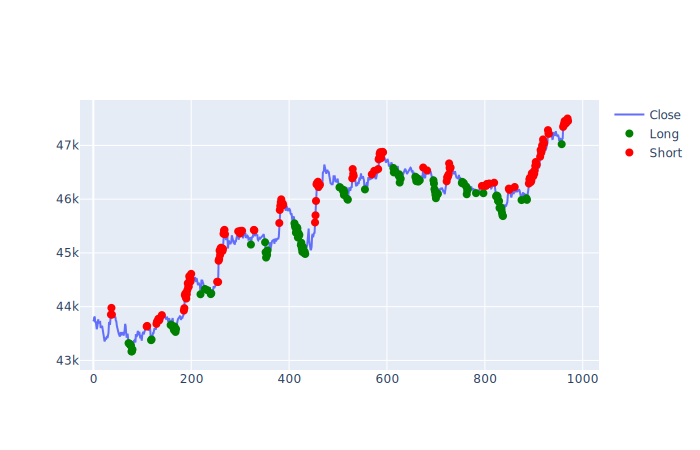

In [156]:
fig = go.Figure()

df_long = df_bands[df_bands["side"] == 1]
df_short = df_bands[df_bands["side"] == -1]


# Add traces
fig.add_trace(go.Scatter(x=df_bands.index, y=df_bands['close'], name='Close'))
fig.add_traces(go.Scatter(x=df_long.index, y=df_long['close'], name='Long',
                          mode='markers', marker=dict(color='green', size=8)))
fig.add_traces(go.Scatter(x=df_short.index, y=df_short['close'], name='Short',
                          mode='markers', marker=dict(color='red', size=8)))

#fig.show()

#static rendering for git
fig.show("svg")